# Analysis of effects of sentiment of tweets on stock prices
In this project our aim is to find how sentiments of tweets on twitter effect the fluctuation of valuation of a company.

We have chosen 5 companies :-


1.   Apple
2.   Tesla
3.   Google
4.   Microsoft
5.   Amazon



### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
!pip install varname
from varname import nameof
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Creating function for sentiment analysis
We have used the vader_lexicon as it works well for internet reviews and tweets as it takes into consideration emojis as well which are quite prevalent in communication methods over internet

In [2]:
# For sentiment analysis, we use VADER library
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

# Sentiment Analysis function
def sentiment_analysis(tweet):
    score = sid.polarity_scores(tweet)["compound"]
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Importing data 
Converting data from csv files to panda data frame

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# changing the directory to read the database

# reading the database
raw_company_db = pd.read_csv("/content/drive/MyDrive/Company.csv")
raw_company_tweet_db = pd.read_csv("/content/drive/MyDrive/Company_Tweet.csv")
raw_tweet_db = pd.read_csv("/content/drive/MyDrive/Tweet.csv")
raw_companyvalue_db = pd.read_csv("/content/drive/MyDrive/CompanyValues.csv")

### Viewing Current Data frames

In [5]:
raw_company_db.head(2)

,ticker_symbol,company_name
0,AAPL,apple
1,GOOG,Google Inc


In [6]:
raw_company_tweet_db.head(2)

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL


In [7]:
raw_tweet_db.head(2)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0


In [8]:
raw_companyvalue_db.head(2)

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63


## Data Cleaning


### Merging the DataFrames to form one single DataFrame

In [9]:
# Part1: Merge raw_company_tweet_db, raw_company_db
raw_company_tweet_db = pd.merge(raw_company_tweet_db, raw_company_db,on='ticker_symbol')

# Part2: Merge raw_company_tweet_db, raw_company_db
raw_tweet_db = pd.merge(raw_tweet_db, raw_company_tweet_db, on="tweet_id")

In [10]:
# Veiwing the marged Dataframe 
raw_tweet_db.head(2)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,company_name
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,apple
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,apple


In [11]:
# Saving the names of dataframes so we can use it if required in future
raw_tweet_db.name = nameof(raw_tweet_db)
raw_companyvalue_db.name = nameof(raw_companyvalue_db)

In [12]:
list_df = [raw_tweet_db, raw_companyvalue_db]

### Missing values check: Let us check if there are any missing values

In [13]:
[print(f"For DataFrame {df.name}, we have missing values check as\n{df.isna().sum()}\n\n") for df in list_df]

For DataFrame raw_tweet_db, we have missing values check as
tweet_id             0
writer           55919
post_date            0
body                 0
comment_num          0
retweet_num          0
like_num             0
ticker_symbol        0
company_name         0
dtype: int64


For DataFrame raw_companyvalue_db, we have missing values check as
ticker_symbol    0
day_date         0
close_value      0
volume           0
open_value       0
high_value       0
low_value        0
dtype: int64




[None, None]

In [14]:
raw_tweet_db.writer = raw_tweet_db.writer.fillna('anonymous')

In [15]:
# let us check if all null values are replaced
raw_tweet_db.isna().sum()

tweet_id         0
writer           0
post_date        0
body             0
comment_num      0
retweet_num      0
like_num         0
ticker_symbol    0
company_name     0
dtype: int64

## Data Engineering


We will convert:
1.   'post_date' column in raw_tweet_db
2.   'day_date' column in raw_companyvalue_db

to datetime for further processing

In [16]:
raw_tweet_db.post_date = pd.to_datetime(raw_tweet_db.post_date, unit="s")
raw_companyvalue_db.day_date = pd.to_datetime(raw_companyvalue_db.day_date)

In [17]:
raw_companyvalue_db.head(2)

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63


On viewing the dataset we see that we have tweets available from 1 Jan 2015 abd the last tweet was on 31 Dec 2019 but the stocks are given till May 2020 so we'll drop those values whose corresponding tweets are not available

In [18]:
raw_companyvalue_db = raw_companyvalue_db[raw_companyvalue_db.day_date < "2020-01-01"]

In [19]:
raw_companyvalue_db.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
103,AAPL,2019-12-31,293.65,25247630,289.93,293.68,289.5200
104,AAPL,2019-12-30,291.52,36059610,289.46,292.69,285.2200
105,AAPL,2019-12-27,289.80,36592940,291.12,293.97,288.1200
106,AAPL,2019-12-26,289.91,23334000,284.82,289.98,284.7000
107,AAPL,2019-12-24,284.27,12119710,284.69,284.89,282.9197


In order to check stock value performance rather than taking in absolute value we take the changes to analyze stocks better

In [20]:
# Let us add column to the stock price dataframe which shows the max stock price fluctuation
raw_companyvalue_db['fluctuation'] = raw_companyvalue_db.high_value - raw_companyvalue_db.low_value

# Let us add column to the stock price dataframe which shows the net rise in stock price
raw_companyvalue_db['price_gain'] = raw_companyvalue_db.close_value - raw_companyvalue_db.open_value

# Let us add column to the stock price dataframe which shows the total valuation at the end of the day
raw_companyvalue_db['total_valuation_EOD'] = raw_companyvalue_db.volume * raw_companyvalue_db.close_value

<ipython-input-20-69a1f3a09aa9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_companyvalue_db['fluctuation'] = raw_companyvalue_db.high_value - raw_companyvalue_db.low_value
<ipython-input-20-69a1f3a09aa9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_companyvalue_db['price_gain'] = raw_companyvalue_db.close_value - raw_companyvalue_db.open_value
<ipython-input-20-69a1f3a09aa9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [21]:
raw_companyvalue_db.head(3)

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,fluctuation,price_gain,total_valuation_EOD
103,AAPL,2019-12-31,293.65,25247630,289.93,293.68,289.52,4.16,3.72,7.413967e+09
104,AAPL,2019-12-30,291.52,36059610,289.46,292.69,285.22,7.47,2.06,1.051210e+10
105,AAPL,2019-12-27,289.80,36592940,291.12,293.97,288.12,5.85,-1.32,1.060463e+10


### Sentiment analysis on the tweets

In [22]:
raw_tweet_db['sentiment'] = raw_tweet_db['body'].apply(lambda x : sentiment_analysis(x))

In [23]:
raw_tweet_db.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,company_name,sentiment
0,550441509175443456,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,apple,neutral
1,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,apple,negative
2,550441732014223360,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,Amazon.com,neutral
3,550442977802207232,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,Tesla Inc,neutral
4,550443807834402816,i_Know_First,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,apple,neutral


In [24]:
# Considering there is a 'comment,  retweet & like' column, we can consider those tweets having the same sentiments
# So for counting the total number of tweets, we add a count column telling the trending score of the tweet which will be addition of all these 3 columns
# Adding 1 to trend score as tweet itself is one of the contributors to itself

raw_tweet_db.insert(7, "trend_score", raw_tweet_db.comment_num + raw_tweet_db.retweet_num + raw_tweet_db.like_num + 1)

Using an anchor to merge two data frames

In [25]:
# Creating Anchor Column for raw_tweet_db
raw_tweet_db.insert(3, "date_str", raw_tweet_db.post_date.astype("str").str.split(" "))
raw_tweet_db.date_str = [element[0] for element in raw_tweet_db.date_str]
raw_tweet_db.insert(0, "anchor", raw_tweet_db.date_str + raw_tweet_db.ticker_symbol)

# Creating Anchor Column for raw_companyvalue_db
raw_companyvalue_db.insert(
    2, "date_str", raw_companyvalue_db.day_date.astype("str").str.split(" ")
)
raw_companyvalue_db.date_str = [element[0] for element in raw_companyvalue_db.date_str]
raw_companyvalue_db.insert(
    0, "anchor", raw_companyvalue_db.date_str + raw_companyvalue_db.ticker_symbol
)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [26]:
# Merging the two dataframe
processed_db = pd.merge(raw_tweet_db, raw_companyvalue_db, on="anchor")

# Let us convert he string date column "date_str_x" to datetime
processed_db.date_str_x = pd.to_datetime(processed_db.date_str_x)

# Since we are aiming to see the impact of tweets on stock value (i.e. rise and fall), we can drop "neutral" sentiments
processed_db = processed_db[processed_db.sentiment != "neutral"]

In [27]:
processed_db.head()

,anchor,tweet_id,writer,post_date,date_str_x,body,comment_num,retweet_num,like_num,trend_score,...,day_date,date_str_y,close_value,volume,open_value,high_value,low_value,fluctuation,price_gain,total_valuation_EOD
1,2015-01-01AAPL,550441672312512512,KeralaGuy77,2015-01-01 00:01:36,2015-01-01,Insanity of today weirdo massive selling. $aap...,0,0,0,1,...,2015-01-01,2015-01-01,110.38,41304780,112.82,113.13,110.21,2.92,-2.44,4.559222e+09
9,2015-01-01AAPL,550444112328261632,GetAOM,2015-01-01 00:11:17,2015-01-01,$UNP $ORCL $QCOM $MSFT $AAPL Top scoring mega ...,0,0,0,1,...,2015-01-01,2015-01-01,110.38,41304780,112.82,113.13,110.21,2.92,-2.44,4.559222e+09
13,2015-01-01AAPL,550445850170642432,JorelLaraKalel,2015-01-01 00:18:12,2015-01-01,@CNBC 15 Top #trades for #2015 #FastMoney $TIF...,0,0,2,3,...,2015-01-01,2015-01-01,110.38,41304780,112.82,113.13,110.21,2.92,-2.44,4.559222e+09
14,2015-01-01AAPL,550447574285418497,btcgemini,2015-01-01 00:25:03,2015-01-01,We searched through hundreds of charts and fou...,0,0,0,1,...,2015-01-01,2015-01-01,110.38,41304780,112.82,113.13,110.21,2.92,-2.44,4.559222e+09
15,2015-01-01AAPL,550447850857828352,JorelLaraKalel,2015-01-01 00:26:09,2015-01-01,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,0,0,2,3,...,2015-01-01,2015-01-01,110.38,41304780,112.82,113.13,110.21,2.92,-2.44,4.559222e+09


### Making a clean data frame for further analysis

In [28]:
# Let us make a clean dataset with only the desired values
clean_db = processed_db[
    [
        "post_date",
        "date_str_x",
        "body",
        "trend_score",
        "ticker_symbol_x",
        "company_name",
        "sentiment",
        "close_value",
        "volume",
        "open_value",
        "high_value",
        "low_value",
        "fluctuation",
        "price_gain",
        "total_valuation_EOD"
    ]
]

In [29]:
# Let us check how many companies do we have in our dataset
print(
    f"In our dataset, we have total {len(clean_db.company_name.value_counts())} companies, namely\n{clean_db.company_name.value_counts()}"
)

In our dataset, we have total 5 companies, namely
apple         766291
Tesla Inc     713108
Amazon.com    426806
Google Inc    357476
Microsoft     188850
Name: company_name, dtype: int64


In [30]:
# after checking the ticker symbol, we see that Google Inc has 2 ticker symbols: GOOG and GOOGL
# Let us change that so all Google Inc tickers have the same symbol as GOOG
clean_db.ticker_symbol_x.replace("GOOGL", "GOOG", inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [31]:
# Let us make datasets for these 5 companies
apple_df = clean_db[clean_db.ticker_symbol_x == "AAPL"]
tesla_df = clean_db[clean_db.ticker_symbol_x == "TSLA"]
amazon_df = clean_db[clean_db.ticker_symbol_x == "AMZN"]
google_df = clean_db[clean_db.ticker_symbol_x == "GOOG"]
microsoft_df = clean_db[clean_db.ticker_symbol_x == "MSFT"]

In [32]:
# For simplicity, we will further form 2 sub dataframes per company based on the sentiments: positive and negative
pos_apple_df = apple_df[apple_df.sentiment == "positive"]
pos_tesla_df = tesla_df[tesla_df.sentiment == "positive"]
pos_amazon_df = amazon_df[amazon_df.sentiment == "positive"]
pos_google_df = google_df[google_df.sentiment == "positive"]
pos_microsoft_df = microsoft_df[microsoft_df.sentiment == "positive"]
neg_apple_df = apple_df[apple_df.sentiment == "negative"]
neg_tesla_df = tesla_df[tesla_df.sentiment == "negative"]
neg_amazon_df = amazon_df[amazon_df.sentiment == "negative"]
neg_google_df = google_df[google_df.sentiment == "negative"]
neg_microsoft_df = microsoft_df[microsoft_df.sentiment == "negative"]

In [33]:
# Let us create dataset with limited values that give us a brief info about rise and fall in total valuation of the company over time

ovr_pos_apple_df = pos_apple_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})
ovr_pos_tesla_df = pos_tesla_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})
ovr_pos_amazon_df = pos_amazon_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})
ovr_pos_google_df = pos_google_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})
ovr_pos_microsoft_df = pos_microsoft_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})

ovr_neg_apple_df = neg_apple_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})
ovr_neg_tesla_df = neg_tesla_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})
ovr_neg_amazon_df = neg_amazon_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})
ovr_neg_google_df = neg_google_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})
ovr_neg_microsoft_df = neg_microsoft_df.groupby(by=["date_str_x","fluctuation", "price_gain", "total_valuation_EOD","sentiment"], as_index=False).agg({"trend_score":pd.Series.sum})

## Data Analysis

### Tesla
Effect of positive tweets on valuation

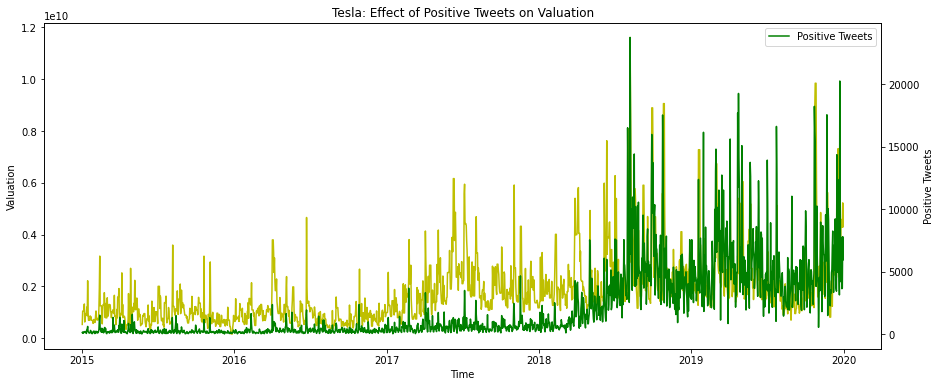

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Tesla: Effect of Positive Tweets on Valuation")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_pos_tesla_df.date_str_x,
    ovr_pos_tesla_df.total_valuation_EOD,
    color="y",
    label="Valuation",
)
ax2.plot(
    ovr_pos_tesla_df.date_str_x,
    ovr_pos_tesla_df.trend_score,
    color="g",
    label="Positive Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Valuation")
ax2.set_ylabel("Positive Tweets")

plt.legend()
plt.show()

<ipython-input-44-a52497c795f1>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


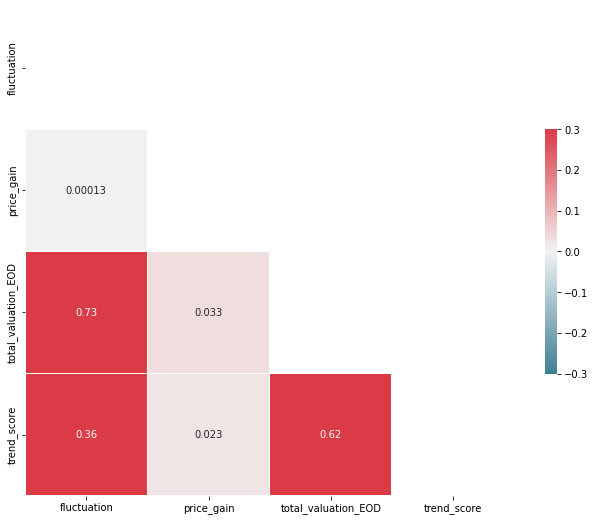

In [44]:
# Create the correlation matrix
corr = ovr_pos_tesla_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph as well as the corelation heatmap that rise in number of positive tweets (trend score) corresponds to increase in the valuation of stock price

Effect of negative tweets on valuation

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


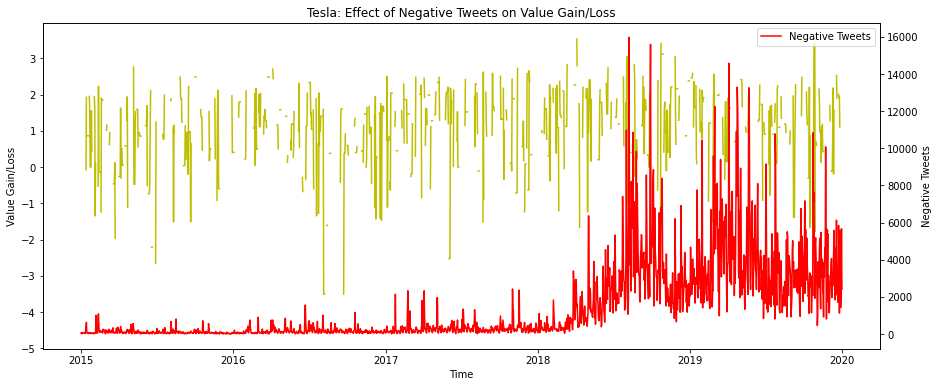

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Tesla: Effect of Negative Tweets on Value Gain/Loss")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_neg_tesla_df.date_str_x,
    np.log(ovr_neg_tesla_df.price_gain),
    color="y",
    label="Value",
)
ax2.plot(
    ovr_neg_tesla_df.date_str_x,
    ovr_neg_tesla_df.trend_score,
    color="r",
    label="Negative Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Value Gain/Loss")
ax2.set_ylabel("Negative Tweets")

plt.legend()
plt.show()

<ipython-input-45-fe242de5ec80>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


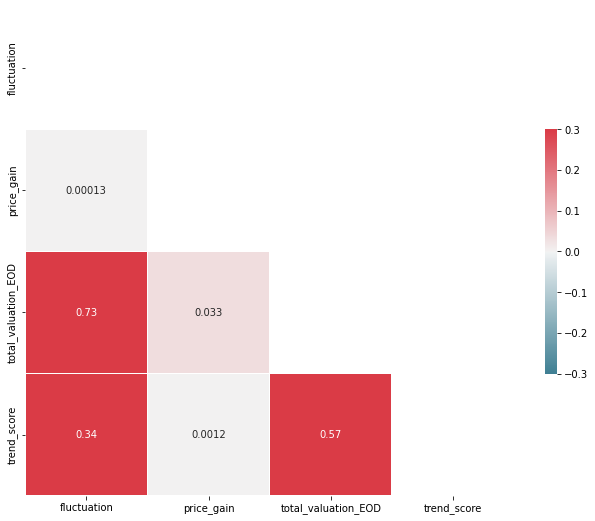

In [45]:
# Create the correlation matrix
corr = ovr_neg_tesla_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph that rise in number of negative tweets (trend score) corresponds to a negative value of price gain. Although we observe that their not mathematically any strong corelation between the same.

### Apple
Effect of positive tweets on valuation

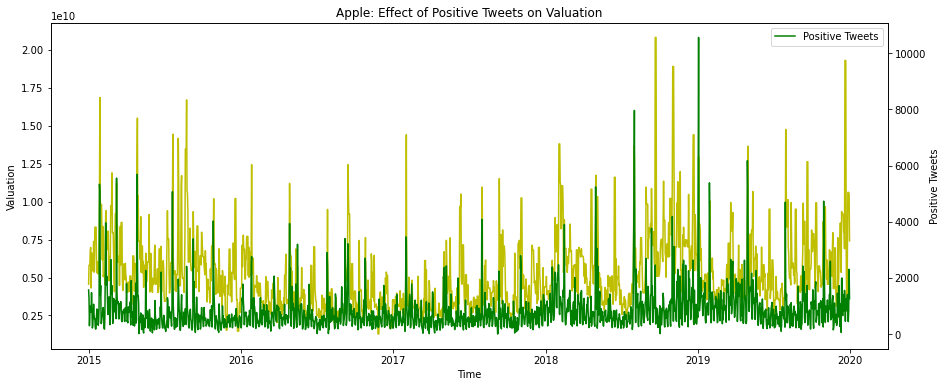

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Apple: Effect of Positive Tweets on Valuation")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_pos_apple_df.date_str_x,
    ovr_pos_apple_df.total_valuation_EOD,
    color="y",
    label="Valuation",
)
ax2.plot(
    ovr_pos_apple_df.date_str_x,
    ovr_pos_apple_df.trend_score,
    color="g",
    label="Positive Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Valuation")
ax2.set_ylabel("Positive Tweets")

plt.legend()
plt.show()

<ipython-input-46-41d70b03804f>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


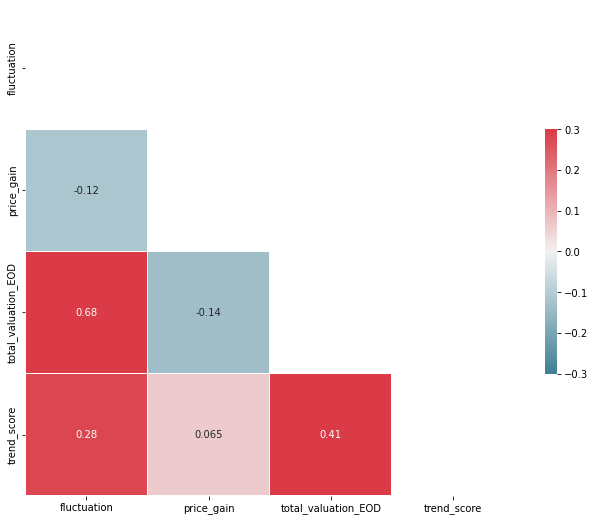

In [46]:
# Create the correlation matrix
corr = ovr_pos_apple_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph as well as the heat map that rise in number of positive tweets (trend score) corresponds to increase in the valuation of stock price. However the corelation seems to be less strong as copared to Tesla

Effect of negative tweets on valuation

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


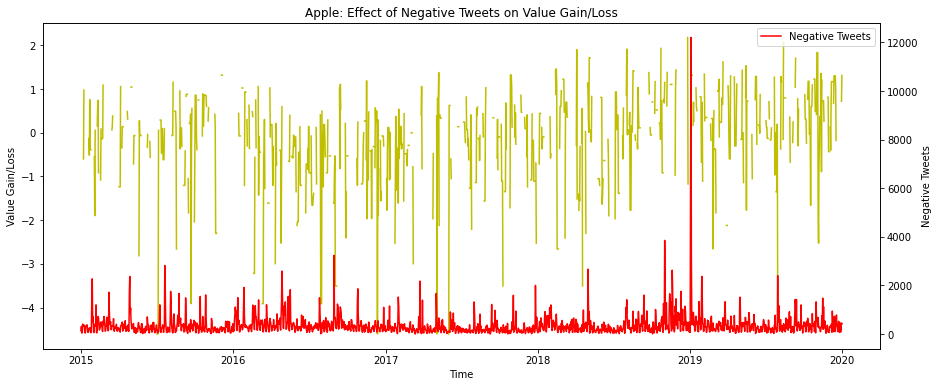

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Apple: Effect of Negative Tweets on Value Gain/Loss")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_neg_apple_df.date_str_x,
    np.log(ovr_neg_apple_df.price_gain),
    color="y",
    label="Value",
)
ax2.plot(
    ovr_neg_apple_df.date_str_x,
    ovr_neg_apple_df.trend_score,
    color="r",
    label="Negative Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Value Gain/Loss")
ax2.set_ylabel("Negative Tweets")

plt.legend()
plt.show()

<ipython-input-47-bfc1b655e838>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


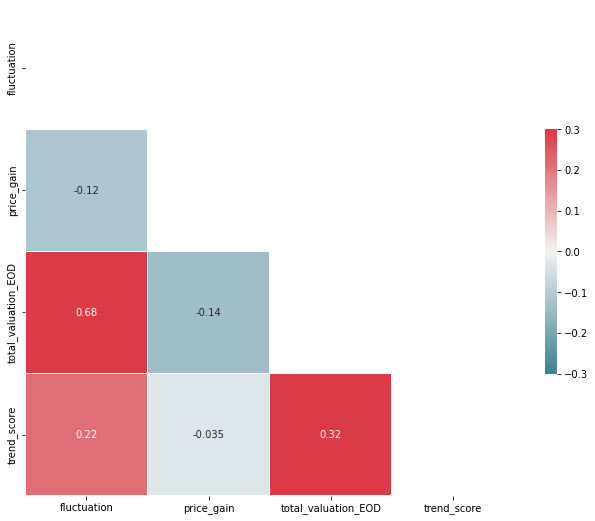

In [47]:
# Create the correlation matrix
corr = ovr_neg_apple_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we observe that there is not a specific corelation between the negative tweets and price gain values as well as the heatmap shows the corelation value to be closer to 0

### Amazon
Effect of positive tweets on valuation

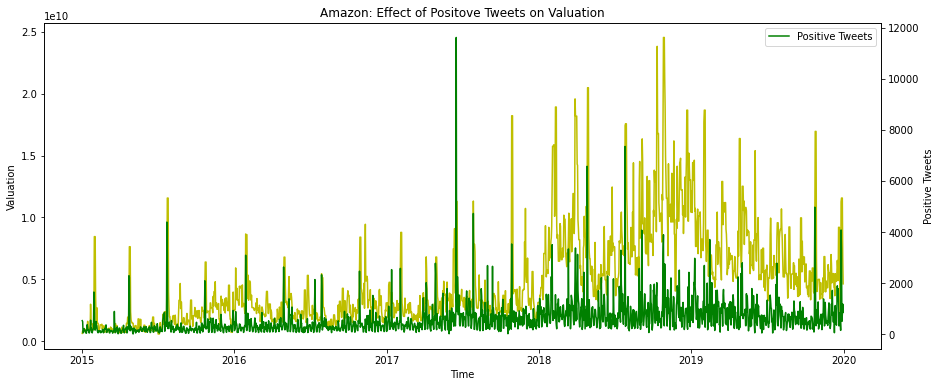

In [38]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Amazon: Effect of Positove Tweets on Valuation")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_pos_amazon_df.date_str_x,
    ovr_pos_amazon_df.total_valuation_EOD,
    color="y",
    label="Valuation",
)
ax2.plot(
    ovr_pos_amazon_df.date_str_x,
    ovr_pos_amazon_df.trend_score,
    color="g",
    label="Positive Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Valuation")
ax2.set_ylabel("Positive Tweets")

plt.legend()
plt.show()

<ipython-input-48-d25d6630875d>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


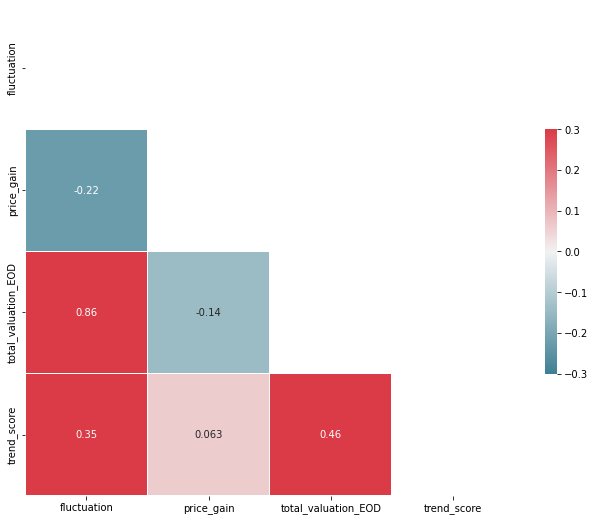

In [48]:
# Create the correlation matrix
corr = ovr_pos_amazon_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph as well as the corealtion heatmap that rise in number of positive tweets (trend score) corresponds to increase in the valuation of stock price

Effect of negative tweets on valuation

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


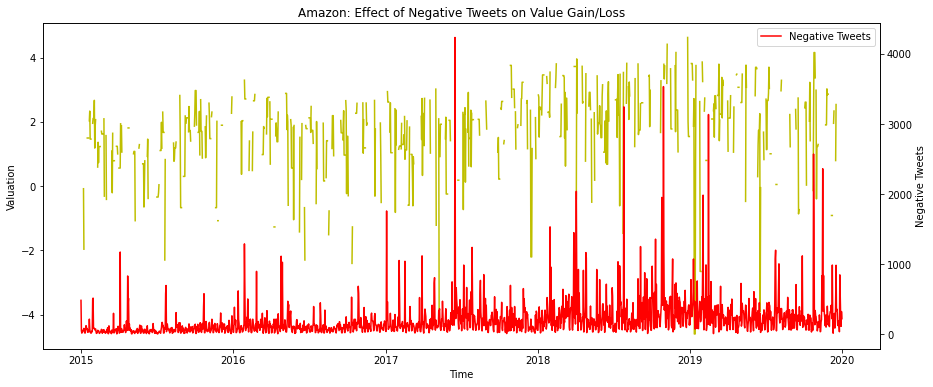

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Amazon: Effect of Negative Tweets on Value Gain/Loss")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_neg_amazon_df.date_str_x,
    np.log(ovr_neg_amazon_df.price_gain),
    color="y",
    label="Value",
)
ax2.plot(
    ovr_neg_amazon_df.date_str_x,
    ovr_neg_amazon_df.trend_score,
    color="r",
    label="Negative Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Valuation")
ax2.set_ylabel("Negative Tweets")

plt.legend()
plt.show()

<ipython-input-49-392963e68b07>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


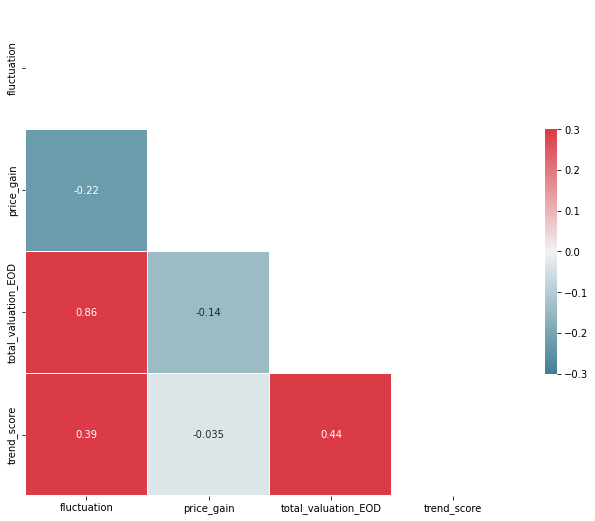

In [49]:
# Create the correlation matrix
corr = ovr_neg_amazon_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph that rise in number of negative tweets (trend score) corresponds to a negative value of price gain. Although the effect is much less in comaprison to Tesla stocks. We also observe that their not mathematically any strong corelation between the same.

### Google
Effect of positive tweets on valuation

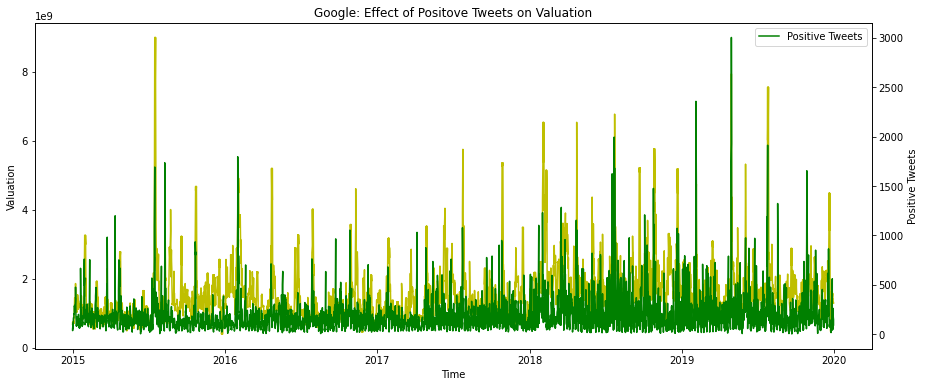

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Google: Effect of Positove Tweets on Valuation")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_pos_google_df.date_str_x,
    ovr_pos_google_df.total_valuation_EOD,
    color="y",
    label="Valuation",
)
ax2.plot(
    ovr_pos_google_df.date_str_x,
    ovr_pos_google_df.trend_score,
    color="g",
    label="Positive Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Valuation")
ax2.set_ylabel("Positive Tweets")

plt.legend()
plt.show()

<ipython-input-50-cb7c70bf8d2b>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


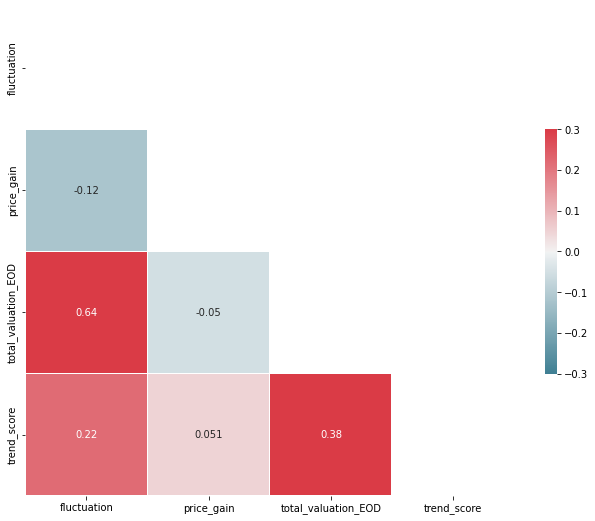

In [50]:
# Create the correlation matrix
corr = ovr_pos_google_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph that rise in number of positive tweets (trend score) corresponds to increase in the valuation of stock price

Effect of negative tweets on valuation

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


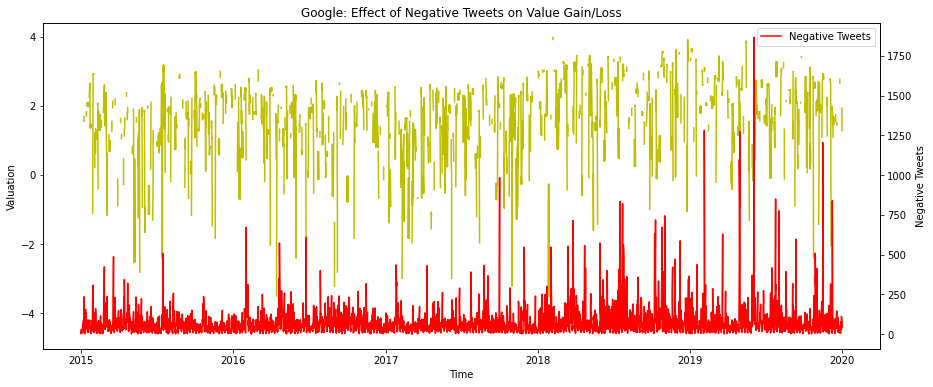

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Google: Effect of Negative Tweets on Value Gain/Loss")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_neg_google_df.date_str_x,
    np.log(ovr_neg_google_df.price_gain),
    color="y",
    label="Value",
)
ax2.plot(
    ovr_neg_google_df.date_str_x,
    ovr_neg_google_df.trend_score,
    color="r",
    label="Negative Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Valuation")
ax2.set_ylabel("Negative Tweets")

plt.legend()
plt.show()

<ipython-input-51-5f48521b3522>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


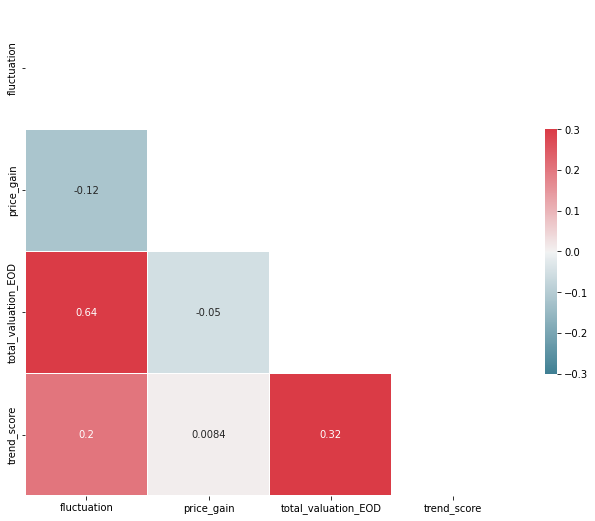

In [51]:
# Create the correlation matrix
corr = ovr_neg_google_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph that rise in number of negative tweets (trend score) corresponds to a negative value of price gain. Another intresting thing is that many of the price drops were actually caused by increase in negative sentiments in some of the precedding days. We also observe that their not mathematically any strong corelation between the same

### Microsoft 
Effect of positive tweets on valuation

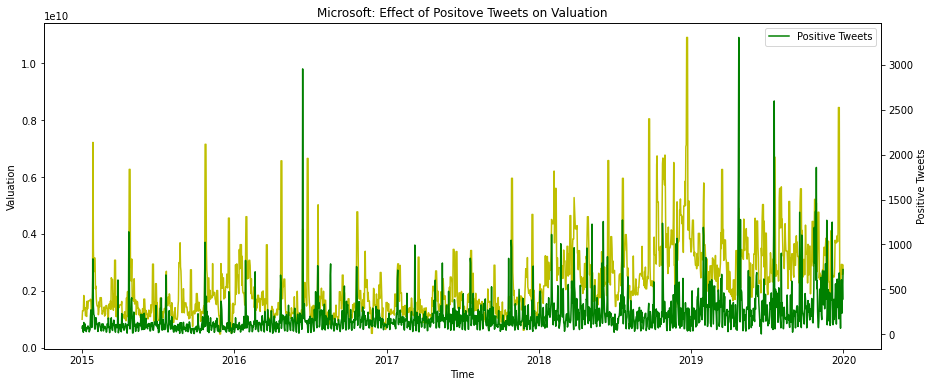

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Microsoft: Effect of Positove Tweets on Valuation")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_pos_microsoft_df.date_str_x,
    ovr_pos_microsoft_df.total_valuation_EOD,
    color="y",
    label="Valuation",
)
ax2.plot(
    ovr_pos_microsoft_df.date_str_x,
    ovr_pos_microsoft_df.trend_score,
    color="g",
    label="Positive Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Valuation")
ax2.set_ylabel("Positive Tweets")

plt.legend()
plt.show()

<ipython-input-52-ccde2d699b99>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


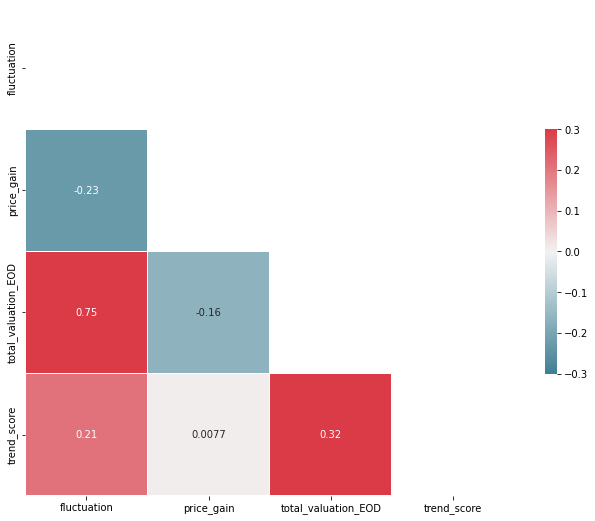

In [52]:
# Create the correlation matrix
corr = ovr_pos_microsoft_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph as well as the corelation heat map that rise in number of positive tweets (trend score) corresponds to increase in the valuation of stock price

Effect of negative tweets on valuation

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


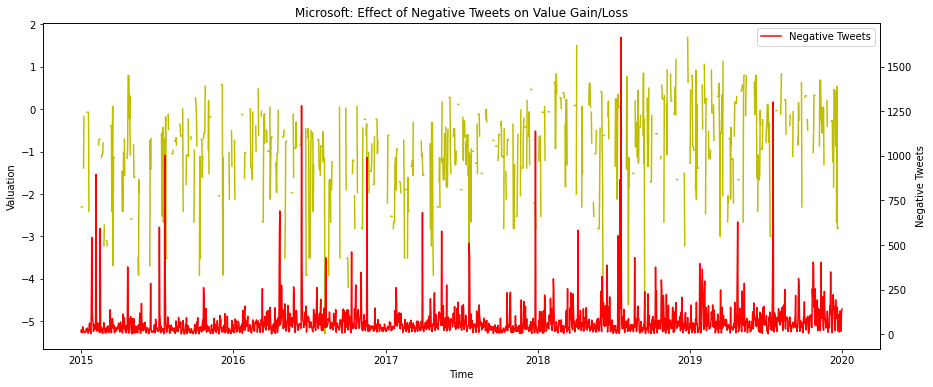

In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 6))
plt.title("Microsoft: Effect of Negative Tweets on Value Gain/Loss")
# since we are plotting 2 line graphs with same X-axis
ax1 = plt.gca()
ax2 = plt.twinx()


ax1.plot(
    ovr_neg_microsoft_df.date_str_x,
    np.log(ovr_neg_microsoft_df.price_gain),
    color="y",
    label="Value",
)
ax2.plot(
    ovr_neg_microsoft_df.date_str_x,
    ovr_neg_microsoft_df.trend_score,
    color="r",
    label="Negative Tweets",
)

ax1.set_xlabel("Time")
ax1.set_ylabel("Valuation")
ax2.set_ylabel("Negative Tweets")

plt.legend()
plt.show()

<ipython-input-53-665ba297fa6c>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


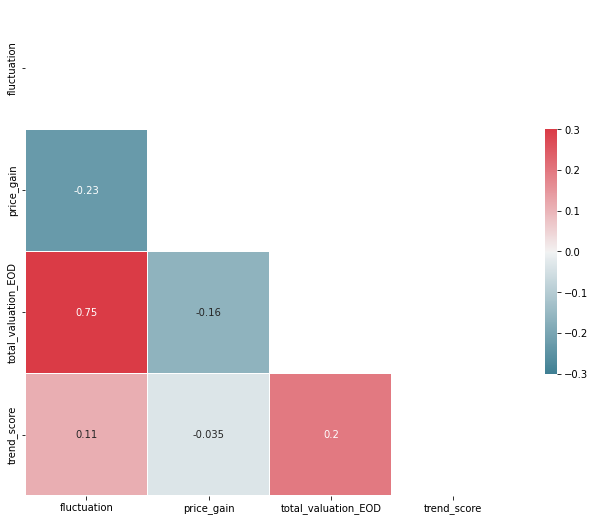

In [53]:
# Create the correlation matrix
corr = ovr_neg_microsoft_df.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)


Here we can clearly see from the pattern graph that rise in number of negative tweets (trend score) corresponds to a negative value of price gain. Here also like Google the price gains were negative if the negative sentiments tweets trend score was higher in previous days. We also observe that their not mathematically any strong corelation between the same

# Results
We came to a conclusion that :-

*   Most of the tweets regarding a company's stocks are neutral
*   Positive tweets generally tend to have positive corelation with change in price as well as the valuation at end of day
*   While going through negative tweets we came across two things:-
    *  They dont have a direct corealtion with price gain or valuation at end of day
    *  Negative sentiments tweet rather than affecting the stock on that itself tend to bring about negative changes in the days following increase of negative sentiment tweets.
*   It is generally not directally possible to predict the movement of stock price just on basis of sentiments of tweets

